In [1]:
import numpy as np
import pandas as pd
import os
import email
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,classification_report,completeness_score
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer

def get_label_from_dirname(dirpath, positive_indicator="spam"):
    if positive_indicator in dirpath:
        return 1
    else:
        return 0 
    
# https://docs.python.org/2.4/lib/standard-encodings.html
def import_messages(root_dir="../data_sets/SpamAssassinMessages/", encoding="cp1256", positive_indicator="spam"):
    
    messages = {"message":[], "label":[]}
    
    for dirpath, dirnames, filenames in os.walk(root_dir, topdown=False):
        for name in filenames:
            fullpath = os.path.join(dirpath, name)
            messages['label'].append(get_label_from_dirname(dirpath=dirpath, positive_indicator=positive_indicator))
            with open(fullpath,'r', encoding=encoding) as f:
                try:
                    msg = email.message_from_file(f)
                    messages['message'].append(msg)
                except UnicodeDecodeError as e:
                    print(f"Error occured with encoding type: {encoding}\n{e}")
                    return
                 
    return messages

def build_message_string(message):
    msg_text = ""
    for msg_part in message.walk():
        if "text" in msg_part.get_content_type():
            msg_text = msg_text + " " + msg_part.get_payload()
    return msg_text

def import_emails(root_dir="../data_sets/SpamAssassinMessages/", encoding="cp1256", positive_indicator="spam"):
    
    messages = import_messages(root_dir=root_dir, 
                               encoding=encoding, 
                               positive_indicator=positive_indicator)
    
    messages['text'] = [build_message_string(message=msg) for msg in messages['message']]

    df = pd.DataFrame(messages)
    first_cols = ['text', 'label']
    df = df.loc[:, first_cols]

    return df

In [2]:
emails = import_emails(root_dir="../data_sets/SpamAssassinMessages/", encoding="cp437", positive_indicator="spam")

In [4]:
from bs4 import BeautifulSoup

def remove_tags(html):
    soup = BeautifulSoup(html, "html.parser")
    for data in soup(['style', 'script']):
        data.decompose()
    return ' '.join(soup.stripped_strings)

emails['text'] = emails['text'].apply(remove_tags)

/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [5]:
from string import punctuation
import re

def clean_email(email):
    email = re.sub("\d+", " ", email)
    email = email.replace('\n', ' ')
    email = email.translate(str.maketrans("", "", punctuation))
    email = email.lower()
    return email

emails['text'] = emails['text'].apply(clean_email)

In [6]:
from nltk.stem.snowball import SnowballStemmer
# nltk.download('wordnet') # uncomment to download 'wordnet'
from nltk.corpus import wordnet as wn

def preproces_text(email):

    words = ""
    stemmer = SnowballStemmer("english")
    email = email.split()
    for word in email:
        words = words + stemmer.stem(word) + " "
    return words

emails['text_stemmed'] = emails['text'].apply(preproces_text)

In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


def remove_stop_words(sentence):
    stop_words = stopwords.words('english')
    new_stopwords = ["c", "b", "e", "f","l"]
    stop_words.extend(new_stopwords)
    word_list=sentence.split()
    clean_sentence=' '.join([w for w in word_list if w.lower() not in stop_words])
    return(clean_sentence)


[nltk_data] Downloading package stopwords to /Users/allen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
emails['text_wo_sw'] = emails['text'].apply(remove_stop_words)

In [9]:
from collections import Counter
df_spam = emails.loc[emails['label']==1]
df_ham = emails.loc[emails['label']==0]


spam_counter = Counter(" ".join(df_spam['text_wo_sw']).split()).most_common(100)
spam_result = pd.DataFrame(spam_counter, columns=['Word', 'Frequency'])

ham_counter = Counter(" ".join(df_ham['text_wo_sw']).split()).most_common(100)
ham_result = pd.DataFrame(ham_counter, columns=['Word', 'Frequency'])



In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc_ham = WordCloud(background_color='white').generate(' '.join(ham_result['Word']))
wc_spam = WordCloud(background_color='white').generate(' '.join(spam_result['Word']))

Non-Spam WordCloud (Top 100 Words


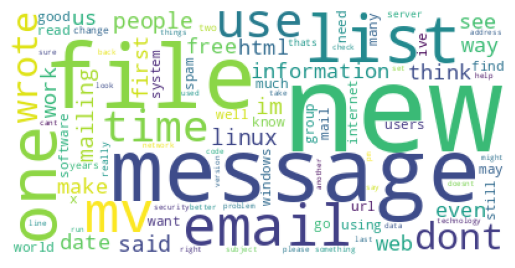

Spam WordCloud (Top 100 Words


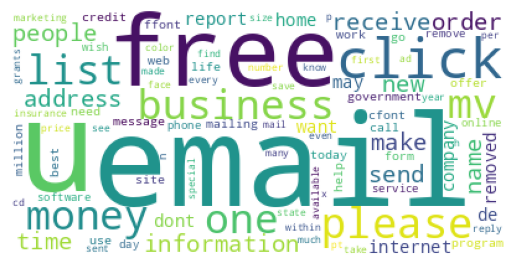

In [17]:
print('Non-Spam WordCloud (Top 100 Words')
plt.imshow(wc_ham)
plt.axis("off")
plt.show()
print('Spam WordCloud (Top 100 Words')
plt.imshow(wc_spam)
plt.axis("off")
plt.show()

In [12]:
#create features and response frames
X = emails['text_stemmed']
y = emails['label']

In [13]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                       stop_words='english')

X = vectorizer.fit_transform(X)


In [14]:

# Create a train/test split using 20% test size.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=0,
                                                    stratify=y)

feature_names = vectorizer.get_feature_names_out()
print("Number of different words: {0}".format(len(feature_names)))
print("Word example: {0}".format(feature_names[5369]))

# Check the split printing the shape of each set.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Number of different words: 84079
Word example: beckley
(7482, 84079) (7482,)
(1871, 84079) (1871,)


              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1391
           1       1.00      0.61      0.76       480

    accuracy                           0.90      1871
   macro avg       0.94      0.80      0.85      1871
weighted avg       0.91      0.90      0.89      1871



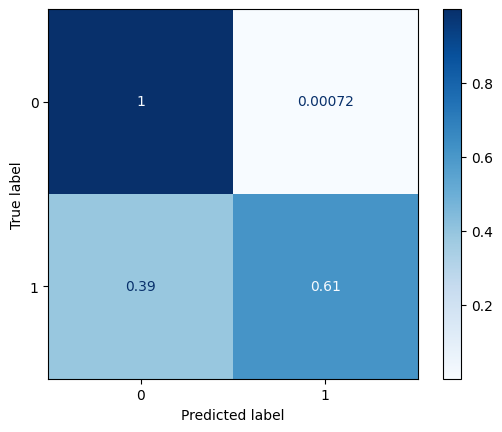

In [15]:
# Create classifier.
clf = MultinomialNB()

# Fit the classifier on the training features and labels.
clf.fit(X_train, y_train)

# Make prediction - Store predictions in a list named pred.
pred = clf.predict(X_test)

accuracy_score(y_test,pred)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay.from_predictions(y_test,pred,normalize='true',cmap='Blues');